In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon May 20 16:22:42 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0              44W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 67.4 gigabytes of available RAM

You are using a high-RAM runtime!


###1.Set Up the **Environment**

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input, Conv2D, Add, UpSampling2D, Dense, Flatten
from tensorflow.keras.layers import Activation, Lambda
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import VGG19

import numpy as np
import matplotlib.pyplot as plt
import glob

import time
import os

###2.Load Data and Pre-processing

####2.1 load data function

In [ ]:
#Load train&val data--DIV2K
def load_data_x4(data_dir=None):
    train_data_x4, val_data_x4 = tfds.load(
        'div2k/bicubic_x4',
        split=['train', 'validation'],
        as_supervised=True,
        data_dir='/content/drive/MyDrive/thesisSR/tensorflow_div2k_x4')
    return train_data_x4, val_data_x4


def load_data_x8(data_dir=None):
    train_data_x8, val_data_x8 = tfds.load(
        'div2k/bicubic_x8',
        split=['train', 'validation'],
        as_supervised=True,
        data_dir='/content/drive/MyDrive/thesisSR/tensorflow_div2k_x8')
    return train_data_x8, val_data_x8



####2.2 pre-processing (resize+nolmalization) function

In [ ]:
#Resize
def preprocess(image, label, target_height=512, target_width=720):
    # resize image and label to a fixed size
    image = tf.image.resize(image, [target_height, target_width])
    label = tf.image.resize(label, [target_height, target_width])

    # normalization
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.cast(label, tf.float32) / 255.0

    return image, label

In [ ]:
#Load test data--Set5,Set14,Rellisur
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)  # Use decode_jpeg for JPEG files
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    return image

def load_dataset(hr_path, lr_path):
    # Get the list of file paths for HR and LR images
    hr_image_files = sorted(glob.glob(hr_path + '/*.png'))  # Make sure to use the correct file extension
    lr_image_files = sorted(glob.glob(lr_path + '/*.png'))

    # Ensure the lengths of the HR and LR lists match
    assert len(hr_image_files) == len(lr_image_files), "HR and LR images count doesn't match"

    # Load the images and create datasets
    hr_images = tf.data.Dataset.from_tensor_slices(hr_image_files).map(load_image)
    lr_images = tf.data.Dataset.from_tensor_slices(lr_image_files).map(load_image)

    # Combine the HR and LR datasets into one dataset (paired)
    dataset = tf.data.Dataset.zip((lr_images, hr_images))
    return dataset

def load_x4test_set5_14():
    # data path
    set5_hr_path = '/content/drive/MyDrive/thesisSR/Set5/original'
    set5_lrx4_path = '/content/drive/MyDrive/thesisSR/Set5/LRbicx4'

    set14_hr_path = '/content/drive/MyDrive/thesisSR/Set14/original'
    set14_lrx4_path = '/content/drive/MyDrive/thesisSR/Set14/LRbicx4'
    # load dataset
    set5_dataset_x4 = load_dataset(set5_hr_path, set5_lrx4_path)
    set14_dataset_x4 = load_dataset(set14_hr_path, set14_lrx4_path)

    return set5_dataset_x4, set14_dataset_x4

def load_x8test_set5_14():
    # data path
    set5_hr_path = '/content/drive/MyDrive/thesisSR/Set5/original'
    set5_lrx8_path = '/content/drive/MyDrive/thesisSR/Set5/LRbicx8'

    set14_hr_path = '/content/drive/MyDrive/thesisSR/Set14/original'
    set14_lrx8_path = '/content/drive/MyDrive/thesisSR/Set14/LRbicx8'

    # load dataset
    set5_dataset_x8 = load_dataset(set5_hr_path, set5_lrx8_path)
    set14_dataset_x8 = load_dataset(set14_hr_path, set14_lrx8_path)

    return set5_dataset_x8, set14_dataset_x8
def load_rellisur():
    # data path
    rellisur_lr_lowlight_path = '/content/drive/MyDrive/thesisSR/rellisur/Test/LRnew'
    rellisur_lr_4_path = '/content/drive/MyDrive/thesisSR/rellisur/Test/NLHR/X2'
    rellisur_lr_8_path = '/content/drive/MyDrive/thesisSR/rellisur/Test/NLHR/X1'
    rellisur_hr_path = '/content/drive/MyDrive/thesisSR/rellisur/Test/NLHR/X4'
    #rellisur_hrx4_path = '/content/drive/MyDrive/thesisSR/rellisur/Test/NLHR/X2'
    #rellisur_hrx8_path = '/content/drive/MyDrive/thesisSR/rellisur/Test/NLHR/X4'

    # load dataset
    rellisur_dataset_x4 = load_dataset(rellisur_hr_path, rellisur_lr_4_path)
    rellisur_dataset_x8 = load_dataset(rellisur_hr_path, rellisur_lr_8_path)
    rellisur_dataset_lowlight = load_dataset(rellisur_hr_path, rellisur_lr_lowlight_path)
    return rellisur_dataset_x4, rellisur_dataset_x8, rellisur_dataset_lowlight

####2.3 random crop function

In [ ]:
def random_crop(lr_img, hr_img, scale, hr_crop_size=96):
    lr_crop_size = hr_crop_size // scale
    lr_img_shape = tf.shape(lr_img)[:2]

    lr_w = tf.random.uniform(shape=(), maxval=lr_img_shape[1] - lr_crop_size + 1, dtype=tf.int32)
    lr_h = tf.random.uniform(shape=(), maxval=lr_img_shape[0] - lr_crop_size + 1, dtype=tf.int32)

    hr_w = lr_w * scale
    hr_h = lr_h * scale

    lr_img_cropped = lr_img[lr_h:lr_h + lr_crop_size, lr_w:lr_w + lr_crop_size]
    hr_img_cropped = hr_img[hr_h:hr_h + hr_crop_size, hr_w:hr_w + hr_crop_size]

    return lr_img_cropped, hr_img_cropped

def prepare_crop_data(train_data, val_data, scale, hr_crop_size=96):
    # Use a lambda to correctly wrap random_crop for use with map
    train_data = train_data.map(lambda img, label: random_crop(img, label, scale, hr_crop_size)).batch(16)
    val_data = val_data.map(lambda img, label: random_crop(img, label, scale, hr_crop_size)).batch(16)
    return train_data, val_data


####2.4 loaded data

In [ ]:
# load and pre-processing(resize and normalization) train data_x4
raw_train_data_x4, raw_val_data_x4 = load_data_x4(data_dir='/content/drive/MyDrive/thesisSR/tensorflow_div2k_x4')
train_data_x4 = raw_train_data_x4.map(preprocess).batch(1)
val_data_x4 = raw_val_data_x4.map(preprocess).batch(1)

In [ ]:
# load and pre-processing train data_x8
raw_train_data_x8, raw_val_data_x8 = load_data_x8(data_dir='/content/drive/MyDrive/thesisSR/tensorflow_div2k_x8')
train_data_x8 = raw_train_data_x8.map(preprocess).batch(1)
val_data_x8 = raw_val_data_x8.map(preprocess).batch(1)

In [ ]:
# load and pre-processing test data SET5,SET14,Rellisur
set5_dataset_x4, set14_dataset_x4 = load_x4test_set5_14()
set5_dataset_x8, set14_dataset_x8 = load_x8test_set5_14()
rellisur_dataset_x4, rellisur_dataset_x8, rellisur_dataset_lowlight = load_rellisur()

In [ ]:
crop_train_x4,crop_val_x4 = prepare_crop_data(raw_train_data_x4, raw_val_data_x4, scale = 4)

###3.Visualize sample images

In [ ]:
def visual_sample_image(dataset):
    for lr_image, hr_image in dataset.take(3):
      if len(lr_image.numpy().shape) == 4:
        # Remove the batch dimension
        lr_image = tf.squeeze(lr_image)
        hr_image = tf.squeeze(hr_image)
      else:
        None

      image_size = lr_image.numpy().shape
      label_size = hr_image.numpy().shape

      plt.figure(figsize=(10, 5))
      plt.subplot(1, 2, 1)
      plt.title(f'Sample: Low Resolution - Size: {image_size}')
      plt.imshow(lr_image.numpy())
      plt.axis('off')

      plt.subplot(1, 2, 2)
      plt.title(f'Sample: High Resolution - Size: {label_size}')
      plt.imshow(hr_image.numpy())
      plt.axis('off')

      plt.show()

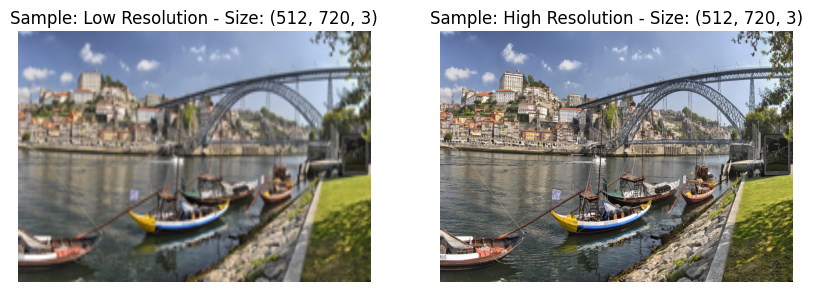

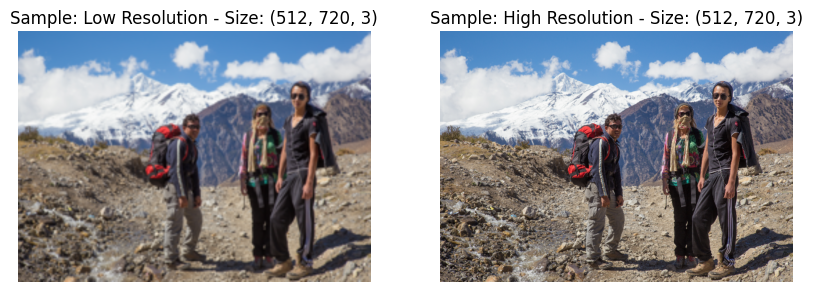

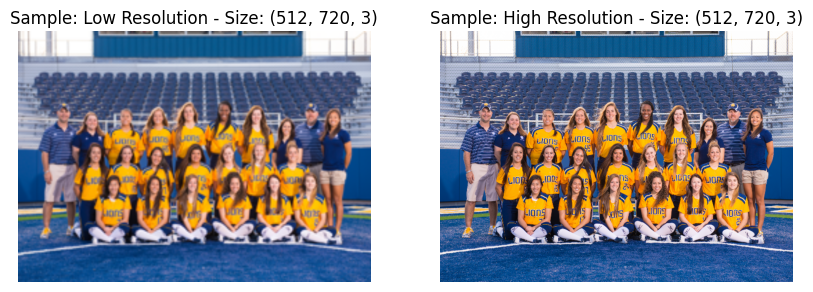

In [ ]:
visual_sample_image(train_data_x8)

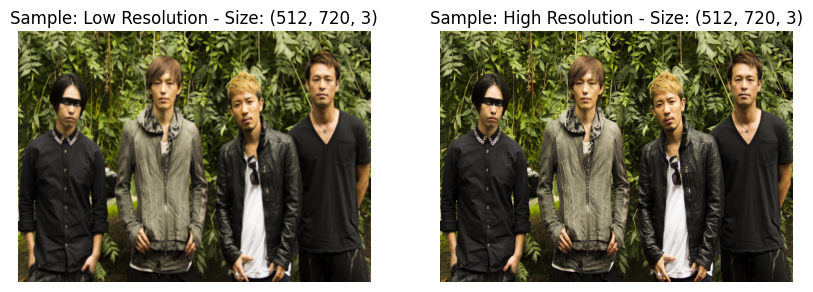

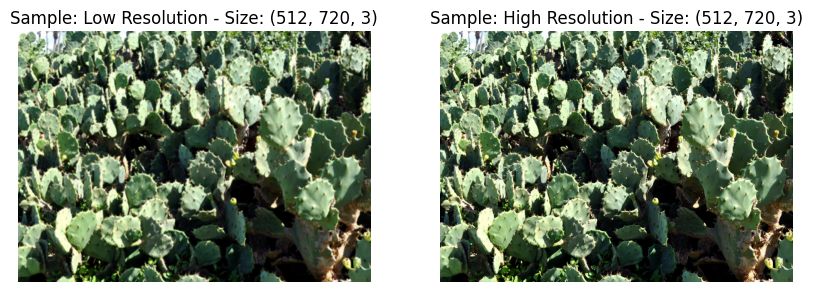

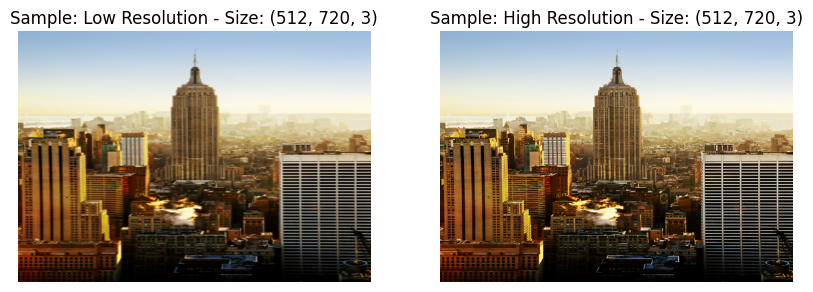

In [ ]:
visual_sample_image(train_data_x4)

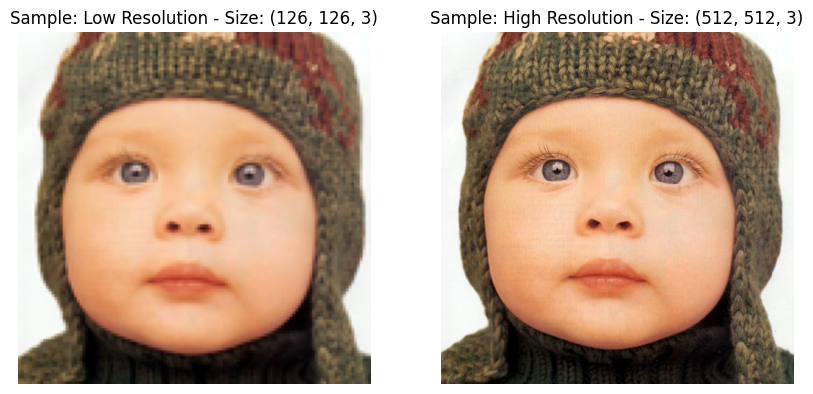

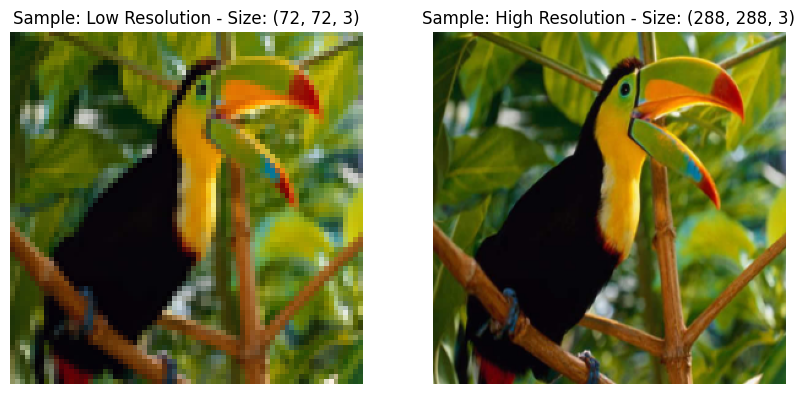

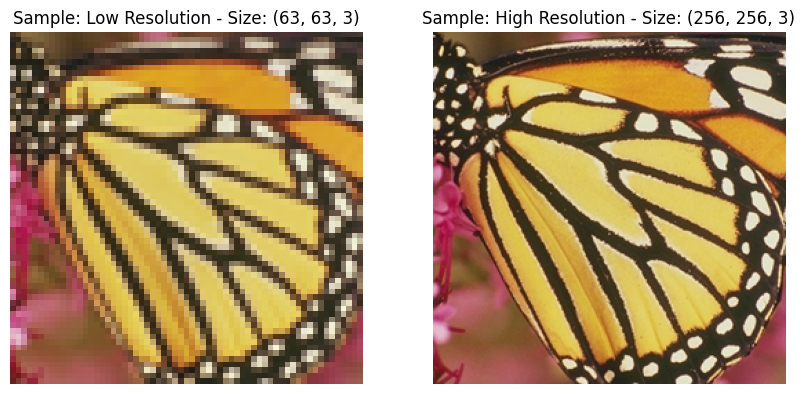

In [ ]:
visual_sample_image(set5_dataset_x4)

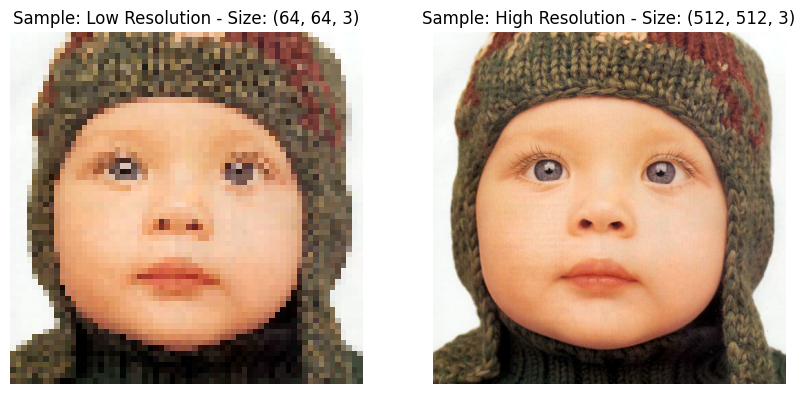

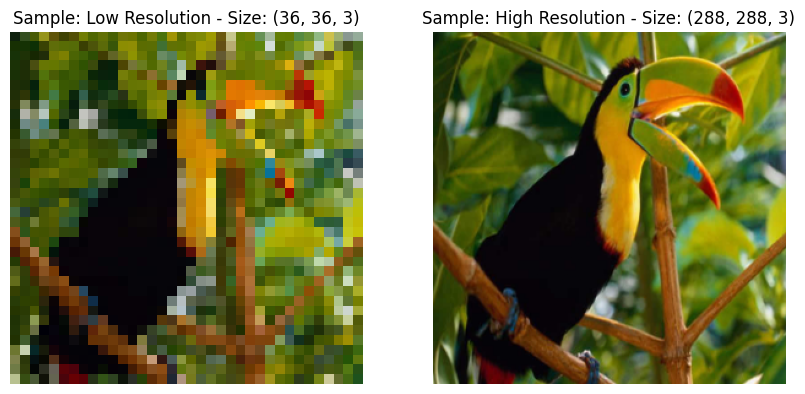

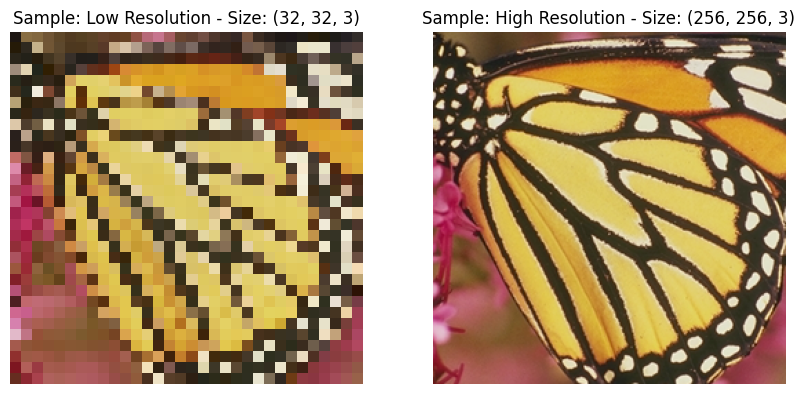

In [ ]:
visual_sample_image(set5_dataset_x8)

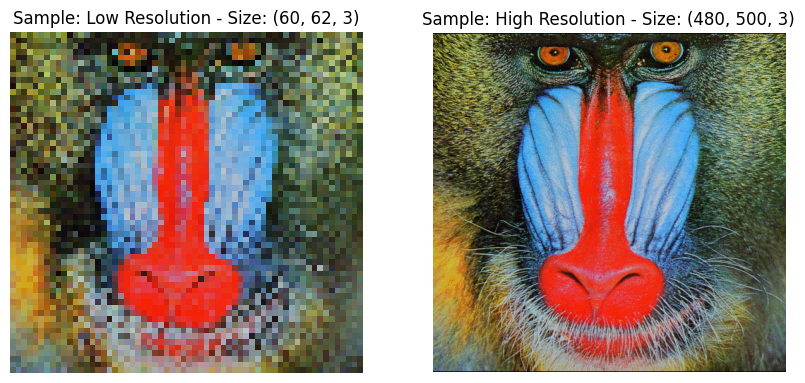

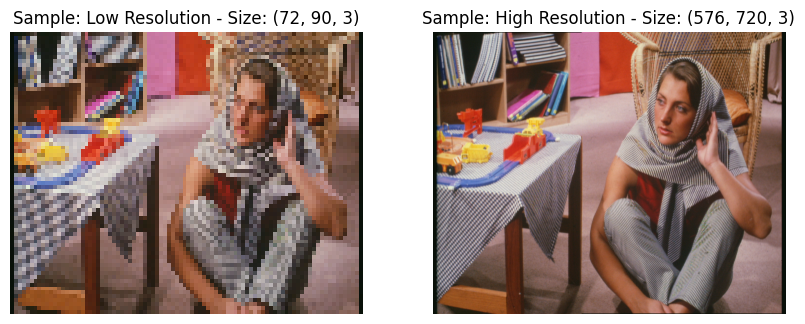

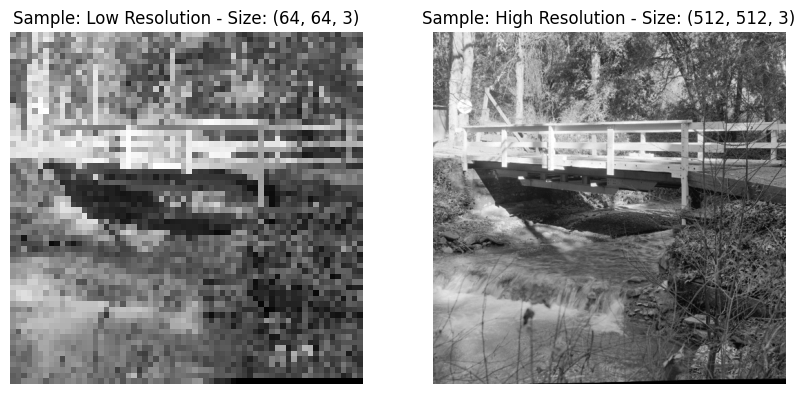

In [ ]:
visual_sample_image(set14_dataset_x8)

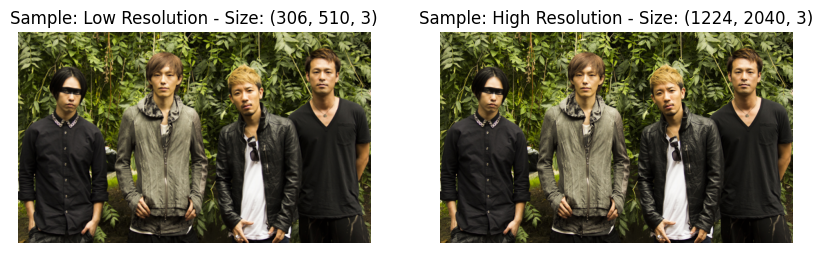

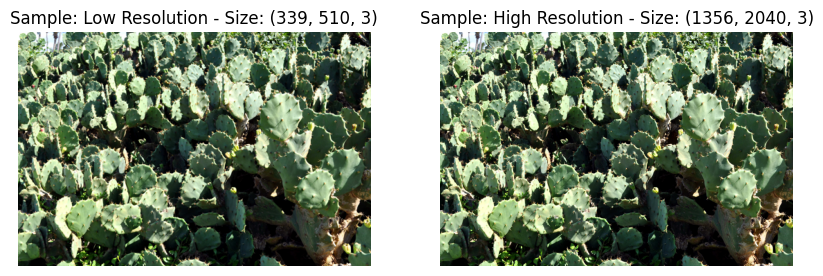

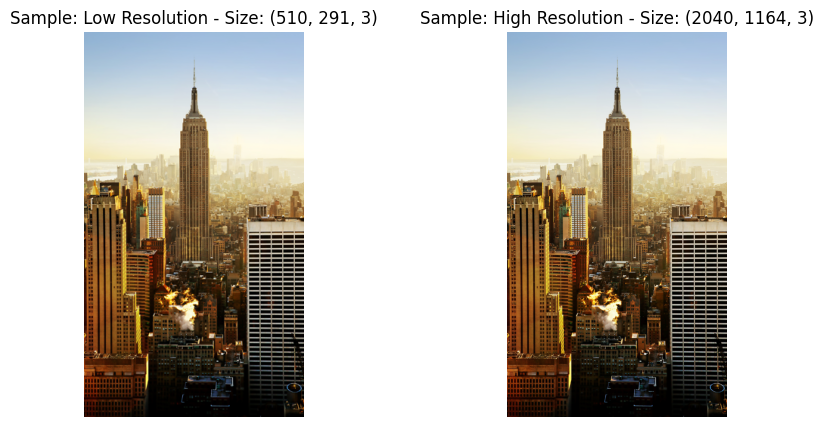

In [ ]:
visual_sample_image(nore_train_data_x4)

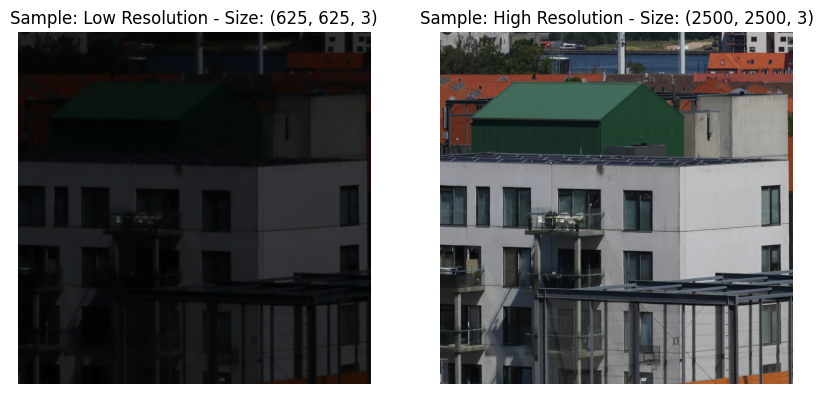

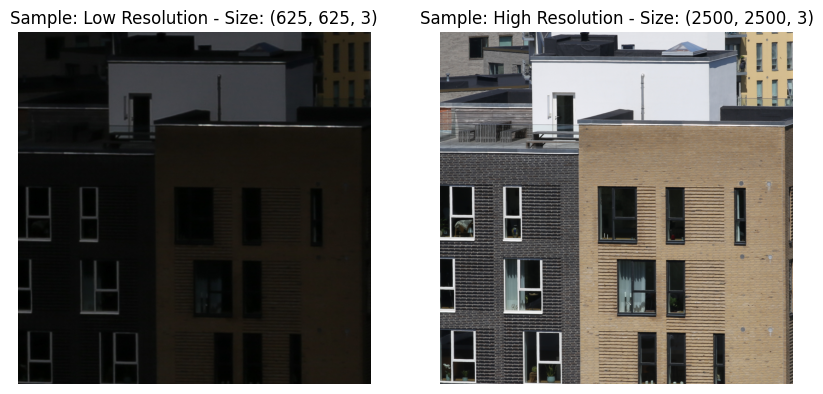

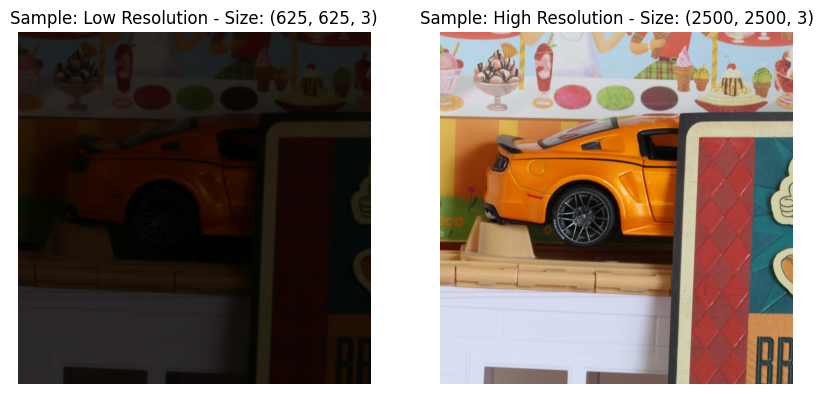

In [ ]:
visual_sample_image(rellisur_dataset_lowlight)

### 4.Model Definition function

####4.1 SRCNN

In [ ]:
def build_srcnn():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters=64, kernel_size=(9, 9), padding='same', activation='relu', input_shape=(None, None, 3)),
        tf.keras.layers.Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu'),
        tf.keras.layers.Conv2D(filters=3, kernel_size=(5, 5), padding='same')
    ])
    return model

####4.2 EDSR

In [ ]:
#The EDSR model consists of multiple residual blocks followed by upsampling layers.
def ResBlock(x, num_filters, scaling):
    x_in = x
    x = Conv2D(num_filters, 3, padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2D(num_filters, 3, padding='same')(x)
    x = x * scaling
    x = Add()([x_in, x])
    return x

def build_EDSR(scale, num_filters=64, num_res_blocks=16, res_block_scaling=0.1):
    inputs = Input(shape=(None, None, 3))
    x = Conv2D(num_filters, 3, padding='same')(inputs)
    x = x_in = Activation('relu')(x)

    for _ in range(num_res_blocks):
        x = ResBlock(x, num_filters, res_block_scaling)

    x = Conv2D(num_filters, 3, padding='same')(x)
    x = Add()([x_in, x])

    # Upscaling
    x = Conv2D(num_filters * (scale ** 2), 3, padding='same')(x)
    x = Lambda(lambda x: tf.nn.depth_to_space(x, scale))(x)
    outputs = Conv2D(3, 3, padding='same')(x)

    model = Model(inputs, outputs)
    return model



###5.Evaluation metrics function-PSNR,SSIM

In [ ]:
# PSNR
def psnr_metric(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)#y_true=high_resolution_image,y_pred = super_resolved_image

# SSIM
def ssim_metric(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

###6.Model Compile and Train function


In [ ]:
# main function
# Set up the training process, compile the model
def srcnn_main(train_data,val_data,epochs,batch_size):
    # define and compile the model
    model = build_srcnn()
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=[psnr_metric, ssim_metric])

    # training
    history = model.fit(train_data, epochs=epochs,batch_size=batch_size, validation_data=val_data)

    # save model
    model.save('srcnn_model.h5')

    return model, history


In [ ]:
def edsr_main(train_data, val_data, scale, epochs, batch_size):
    train_data, val_data = prepare_crop_data(train_data, val_data, scale = scale)

    model = build_EDSR(scale=scale, num_filters=64, num_res_blocks=16, res_block_scaling=0.1)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0001,epsilon=1e-08),
        loss='mean_absolute_error',
        metrics=[psnr_metric, ssim_metric])

    history = model.fit(train_data, epochs=epochs, validation_data=val_data, batch_size=batch_size)
    return model,history

###7.Visualization and Evaluation function

In [ ]:
def summarize_diagnostics(history):
	# Plot training & validation loss values
  plt.figure(figsize=(12, 4))
  plt.subplot(1, 3, 1)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')

  # Plot training & validation PSNR values
  plt.subplot(1, 3, 2)
  plt.plot(history.history['psnr_metric'])
  plt.plot(history.history['val_psnr_metric'])
  plt.title('Model PSNR')
  plt.ylabel('PSNR')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')

  # Plot training & validation SSIM values
  plt.subplot(1, 3, 3)
  plt.plot(history.history['ssim_metric'])
  plt.plot(history.history['val_ssim_metric'])
  plt.title('Model SSIM')
  plt.ylabel('SSIM')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')

  plt.tight_layout()
  plt.show()

In [ ]:

def evaluate_and_visualize_model(model, dataset):
    psnr_values = []
    ssim_values = []

    # Set the number of samples you want to visualize
    num_samples_to_visualize = 3
    samples_visualized = 0

    for lr_img, hr_img in dataset:
        # Ensure lr_img has a batch dimension
        lr_img_batched = tf.expand_dims(lr_img, axis=0)

        # Predict the super-resolved image
        sr_img = model.predict(lr_img_batched)

        # Remove the batch dimension from sr_img and ensure both tensors have the same shape
        sr_img = tf.squeeze(sr_img)

        # Ensure that the predicted image and the label have the same dimensions
        sr_img = tf.image.resize(sr_img, tf.shape(hr_img)[:2], method='bicubic')

        # Normalize the images if they are not in the range [0, 255]
        lr_img = lr_img * 255
        sr_img = sr_img * 255
        hr_img = hr_img * 255

        # Compute PSNR and SSIM
        psnr = tf.image.psnr(hr_img, sr_img, max_val=255)
        ssim = tf.image.ssim(hr_img, sr_img, max_val=255)
        psnr_values.append(psnr)
        ssim_values.append(ssim)

        # Visualize the images
        if samples_visualized < num_samples_to_visualize:
            plt.figure(figsize=(15, 5))

            plt.subplot(1, 3, 1)
            plt.imshow(tf.cast(lr_img, tf.uint8))
            plt.title('Low Resolution')
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.imshow(tf.cast(sr_img, tf.uint8))
            plt.title('Super Resolved')
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.imshow(tf.cast(hr_img, tf.uint8))
            plt.title('High Resolution')
            plt.axis('off')

            plt.show()

            samples_visualized += 1

    mean_psnr = tf.reduce_mean(psnr_values)
    mean_ssim = tf.reduce_mean(ssim_values)
    print(f"mean psnr = {mean_psnr}")
    print(f"mean ssim = {mean_ssim}")
    return mean_psnr, mean_ssim

